# Описание проекта

Я — аналитик крупного интернет-магазина. Вместе с отделом маркетинга мы подготовили список гипотез для увеличения выручки.<br>
*Поставлены задачи:*<br>
- Приоритизировать гипотезы<br>
- Запустить A/B-тест<br>
- Проанализировать результаты. 
<br><br>


***Описание данных***<br>

**Данные для первой части:<br>
Датафрейм hypothesis:**

- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.
<br><br>


**Данные для второй части:<br>
Датафрейм orders:**
- transactionId — идентификатор заказа;<br>
- visitorId — идентификатор пользователя, совершившего заказ;<br>
- date — дата, когда был совершён заказ;<br>
- revenue — выручка заказа;<br>
- group — группа A/B-теста, в которую попал заказ.<br>

**Датафрейм visitors:**
- date — дата;<br>
- group — группа A/B-теста;<br>
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста<br>

### Загрузим блиблиотеки и посмотрим на данные

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy
import datetime as dt
from scipy import stats as st
from datetime import datetime, timedelta
import warnings
warnings.simplefilter('ignore')
pd.options.display.max_colwidth = 1

In [2]:
try:    
    hypothesis = pd.read_csv('/datasets/hypothesis.csv', sep=',')
except:
    hypothesis = pd.read_csv('https://code.s3.yandex.net/datasets/hypothesis.csv', sep=',')
try:
    orders = pd.read_csv('/datasets/orders.csv', sep=',')
except:
    orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders.csv', sep=',')
try:    
    visitors = pd.read_csv('/datasets/visitors.csv', sep=',')
except:
    visitors = pd.read_csv('https://code.s3.yandex.net/datasets/visitors.csv', sep=',')

In [3]:
#Напишем простую функцию для просмотра информации в данных
def information(data):
    display(data.head(5))
    display(data.info())
    print('Количество дубликатов:',data.duplicated().sum())
    print("Количество Пропусков в столбцах:\n", data.isna().sum())

In [4]:
information(hypothesis)

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


None

Количество дубликатов: 0
Количество Пропусков в столбцах:
 Hypothesis    0
Reach         0
Impact        0
Confidence    0
Efforts       0
dtype: int64


In [5]:
information(orders)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


None

Количество дубликатов: 0
Количество Пропусков в столбцах:
 transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64


In [6]:
information(visitors)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


None

Количество дубликатов: 0
Количество Пропусков в столбцах:
 date        0
group       0
visitors    0
dtype: int64


**Пропусков и дубликатов не обнаружено, необходимо подправить дату и привести названия столбцов к нижнему регистру. Замечены столбцы без разделения (transactionId, visitorId), тоже переименуем**

In [7]:
orders['date'] = pd.to_datetime(orders['date'])
visitors['date'] = pd.to_datetime(visitors['date'])

In [8]:
#Чтобы вручную через rename не переименовывать каждый столбец, напишем функцию
for i in [visitors, orders, hypothesis]:
    i.columns = [x.lower().replace(' ', '_') for x in i.columns.values]
orders = orders.rename(columns={'transactionid': 'transaction_id', 'visitorid': 'visitor_id'}) 

In [9]:
#Проверка
#display(hypothesis)
#display(orders)
#display(visitors)

**Промежуточный итог:**<br>
Пропусков и дубликатов не обнаружено, исправлен параметр даты, названия столбцов приведены корректному регистру. 

### Часть первая. Приоритизация гипотез.
**Задачи**<br>
- Применить фреймворк ICE для приоритизации гипотез. Отсортировать их по убыванию приоритета.
- Применить фреймворк RICE для приоритизации гипотез. Отсортировать их по убыванию приоритета.
- Указать, как изменилась приоритизация гипотез при применении RICE вместо ICE. Объяснить, почему так произошло.

In [10]:
# создадим столбец ice и отсортируем по убыванию приоритета
# новый параметр округлим до 2 знаков после запятой
hypothesis['ice'] = round((hypothesis['impact'] * hypothesis['confidence'])/hypothesis['efforts'], 2)
display(hypothesis[['hypothesis', 'ice']].sort_values(by='ice', ascending=False))

,hypothesis,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


**Вывод наиболее приоритетные гипотезы по ICE:**

- Запустить акцию, дающую скидку на товар в день рождения;
- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей;
- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок

In [11]:
#создаем столбец rice 
# новый параметр округлим до 2 знаков после запятой
hypothesis['rice'] = round((hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'])/hypothesis['efforts'], 2)
display(hypothesis[['hypothesis', 'rice']].sort_values(by='rice', ascending=False))

,hypothesis,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


**Вывод наиболее приоритетные гипотезы по ICE:**

- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок;
- Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа;
- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей

**Вывод  первой части:**
В обоих случаях (ICE и RICE) гипотеза №0 и №7 ("Добавить два новых канала привлечения трафика" и "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок") входят в тройку, что показывает перспективу дальнейшего развития гипотез.<br>
Наболее перспективная гипотеза по ICE под номером 8(Запустить акцию на скидку к дню рождения) опустилось на пятое место при расчете RICE. Это объясняется показателем reach - количество пользователей, которое затронет изменение, равно 10 в случае с гипотезой №7 и минимальное значение (1) у гипотезы №8

### Часть вторая. Анализ A/B-теста
**Задачи:**
- Постройте график кумулятивной выручки по группам. Сделайте выводы и предположения.
- Постройте график кумулятивного среднего чека по группам. Сделайте выводы и предположения.
- Постройте график относительного изменения кумулятивного среднего чека группы B к группе A. Сделайте выводы и предположения.
- Постройте график кумулятивного среднего количества заказов на посетителя по группам. Сделайте выводы и предположения.
- Постройте график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A. Сделайте выводы и предположения.
- Постройте точечный график количества заказов по пользователям. Сделайте выводы и предположения.
- Посчитайте 95-й и 99-й перцентили количества заказов на пользователя. Выберите границу для определения аномальных пользователей.
- Постройте точечный график стоимостей заказов. Сделайте выводы и предположения.
- Посчитайте 95-й и 99-й перцентили стоимости заказов. Выберите границу для определения аномальных заказов.
- Посчитайте статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным. Сделайте выводы и предположения.
- Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделайте выводы и предположения.
- Посчитайте статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным. Сделайте выводы и предположения.
- Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделайте выводы и предположения.
- Примите решение по результатам теста и объясните его. Варианты решений:
1. Остановить тест, зафиксировать победу одной из групп.
2. Остановить тест, зафиксировать отсутствие различий между группами.
3. Продолжить тест.

#### Проверим что пользователи не попали в обе группы

In [12]:
doubles = (orders.groupby(['visitor_id'])
            .agg({'group' : 'nunique',
                  'transaction_id' : 'count',
                  'revenue' : 'sum'})
            .reset_index()
           )
print(f'Пользователей, попавших в обе группы: {doubles[doubles.group != 1]["visitor_id"].count()}')
print(f"Сумма заказов этих пользователей {doubles[doubles.group != 1]['revenue'].sum()}")
print(f"Количество заказов {doubles[doubles.group != 1]['transaction_id'].sum()}")

Пользователей, попавших в обе группы: 58
Сумма заказов этих пользователей 1558935
Количество заказов 181


Выходит 58 пользователей находятся сразу и в группе А и в группе В, они сделали 181(из 1197) заказ на сумму 1 558 935р. Неизвестно какая из версия А или В повлияла на их решение о заказе, поэтому исключим данных пользователей(это будет уже критическая отметка в 15% потери данных от заказов, далее исключать уже ничего не будем)

In [13]:
d_list = list(doubles[doubles.group != 1]['visitor_id'])
orders = orders.query('visitor_id not in @d_list')

#### Построим график кумулятивной выручки по группам

In [14]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date', 'group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transaction_id': 'nunique',
            'visitor_id': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

# получаем агрегированные кумулятивные по дням данные о посетителях 
visitorsAggregated = datesGroups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])

# объединяем кумулятивные данные в одной таблице
cumulativeData = ordersAggregated.merge(
    visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group']
)
cumulativeData.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]

display(cumulativeData.head())

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845


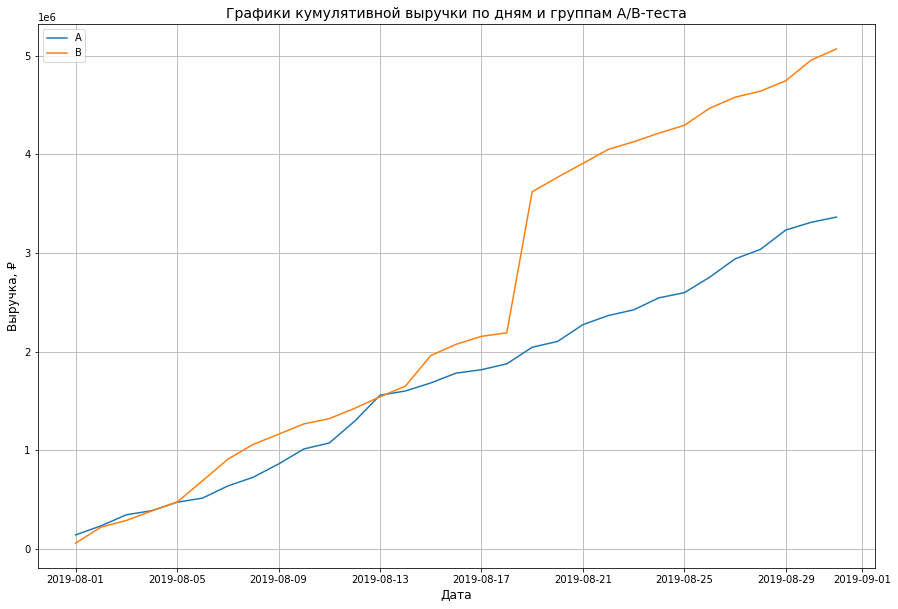

In [15]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulative_revenue_a = cumulativeData[cumulativeData['group']=='A'][['date', 'revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulative_revenue_b = cumulativeData[cumulativeData['group']=='B'][['date', 'revenue', 'orders']]

# задаём размер для графиков
plt.figure(figsize=(15, 10))

# строим график выручки группы А
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue'], label='A')

# строим график выручки группы B
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue'], label='B')

plt.grid(visible=True)
plt.title('Графики кумулятивной выручки по дням и группам A/B-теста', fontsize=14)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Выручка, ₽', fontsize=12)
plt.legend() 
plt.show()

**Вывод:**<br>
Выручка практически равномерно увеличивается в обеих группах за представленный период. Можно заметить, что график выручки группы B в одной точке резко вырос и далее продолжил рост более плавно. Это может дать сигнал о скачке числа заказов, либо сильно вырос чек заказа.

#### Построим график кумулятивного среднего чека по группам

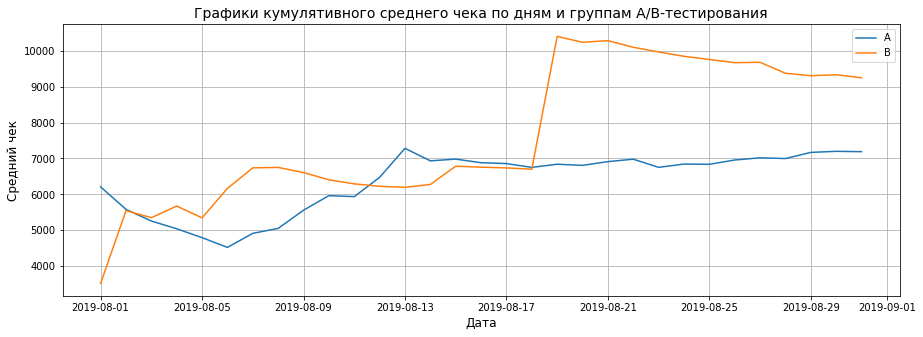

In [16]:
plt.figure(figsize=(15, 5))
plt.plot(cumulative_revenue_a['date'],
         cumulative_revenue_a['revenue']/cumulative_revenue_a['orders'],
         label='A')
plt.plot(cumulative_revenue_b['date'],
         cumulative_revenue_b['revenue']/cumulative_revenue_b['orders'],
         label='B')
plt.grid(visible=True)
plt.title('Графики кумулятивного среднего чека по дням и группам A/B-тестирования', fontsize=14)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Средний чек', fontsize=12)
plt.legend() 
plt.show()

**Вывод:**<br> В группе А видно падения в самом начале теста и затем резкий скачок вплоть до 13.08.2019. Далее чек находится на одном уровне с незначительными колебаниями. В группе В с первого дня заметен рост и затем резкий скачок (возможно некоторые пользователи закупили большую партию товара в этот день), далее до конца теста идет спад. Однако средний чек группы Б после скачка все равно выше чем в группе А
Действительно рост выручки в группе Б связан с резким скачком среднего чека.


#### Построим график относительного изменения среднего чека группы B к группе A

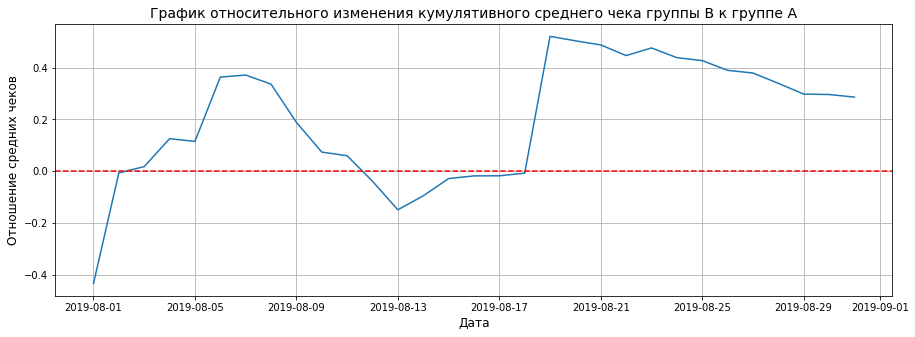

In [17]:
# собираем данные в одном датафрейме
merged_cumulative_revenue = cumulative_revenue_a.merge(
    cumulative_revenue_b,
    left_on='date',
    right_on='date',
    how='left',
    suffixes=['A', 'B'])

# задаём размер для графика
plt.figure(figsize=(15, 5))

# cтроим отношение средних чеков
plt.plot(merged_cumulative_revenue['date'],
         (merged_cumulative_revenue['revenueB']/
          merged_cumulative_revenue['ordersB'])/
         (merged_cumulative_revenue['revenueA']/
          merged_cumulative_revenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='red', linestyle='--')

plt.grid(visible=True)
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A', fontsize=14)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Отношение средних чеков', fontsize=12)
plt.show()

**Судя по графику средний чек пользователей группы Б превышает чек группы А. В некоторых точках видны резкие скачки, это говорит о наличии крупных заказов.**

#### Построим график кумулятивного среднего количества заказов на посетителя по группам.

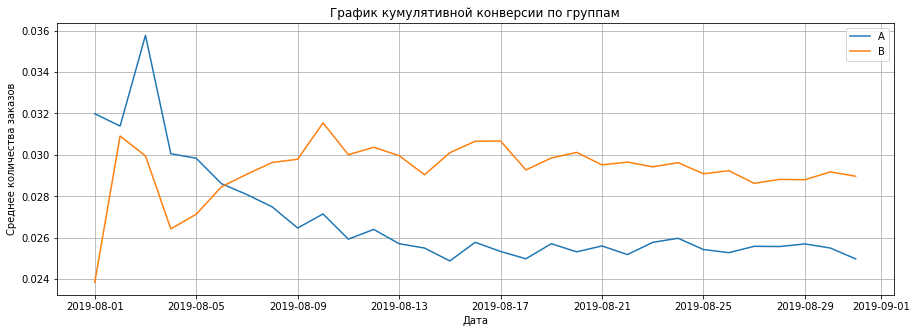

In [18]:
# считаем конверсию на пользователя
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим график
plt.figure(figsize=(15, 5))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()
plt.grid(visible=True)
plt.title("График кумулятивной конверсии по группам")
plt.ylabel("Среднее количества заказов")
plt.xlabel("Дата")
plt.show()

**Вывод:**<br>
Видно пиковый всплекс заказов с разницей в 1 день в группе А и в группе В на момент начала теста.  Конверсия группы A упала относительно первоначальных значений и зафиксировалась на уровне к середине теста. Конверсия группы B начала расти и далее зафиксировалась, показывая более высокий показатель чем группа А

#### Построим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A. 

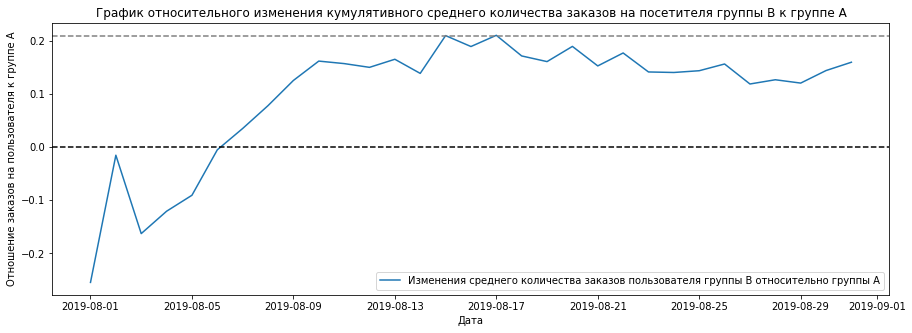

In [19]:
mergedCumulativeConversions = (cumulativeDataA[['date','conversion']]
                               .merge(cumulativeDataB[['date','conversion']],
                                      left_on='date', 
                                      right_on='date', 
                                      how='left', 
                                      suffixes=['A', 'B']))
plt.figure(figsize=(15, 5))
plt.plot(mergedCumulativeConversions['date'],
         mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1,
         label="Изменения среднего количества заказов пользователя группы B относительно группы A")
plt.legend()
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.21, color='grey', linestyle='--')
plt.title("График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A")
plt.ylabel("Отношение заказов на пользователя к группе А")
plt.xlabel("Дата")
plt.show()

**Судя по графику, виден относительный прирост количества заказов пользователей группы В по сравнению с группой А в среднем на 15% (20% в пике)**

#### Построим точечный график количества заказов по пользователям.

In [20]:
# число заказов(транзакций) по пользователям
orders_by_users = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
    .sort_values(by='transaction_id', ascending=False)
    .rename(columns={'transaction_id': 'orders'})
)

display(orders_by_users.sort_values(by= 'orders', ascending = False).head(10))

,visitor_id,orders
908,3967698036,3
478,2108163459,3
687,2988190573,3
890,3908431265,3
138,611059232,3
632,2742574263,3
55,249864742,3
807,3469608676,2
792,3379260072,2
787,3362039251,2


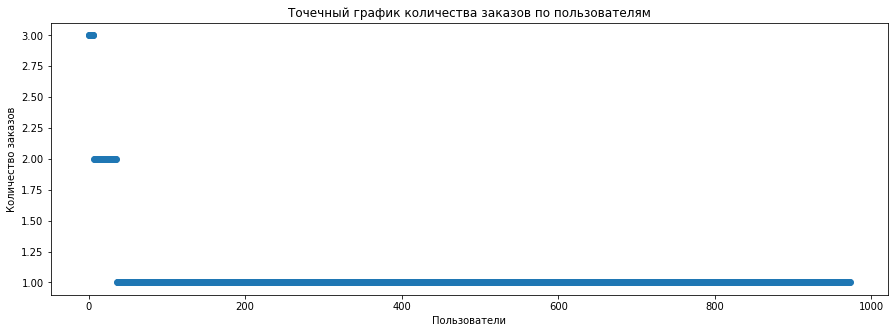

In [21]:
# Построим точечный график количества заказов по пользователям
x_values = pd.Series(range(0, len(orders_by_users)))
plt.figure(figsize=(15, 5))
plt.scatter(x_values, orders_by_users['orders'])
plt.title("Точечный график количества заказов по пользователям")
plt.ylabel("Количество заказов")
plt.xlabel("Пользователи")
plt.show()

**Судя по графику в большинстве случаев один пользователь делал один заказ, реже - два. Три заказа это максимальное число и таких пользователей всего 7.**

#### Посчитаем 95-й и 99-й перцентили количества заказов на пользователя

In [22]:
display(np.percentile(orders_by_users['orders'], [95, 99]))

array([1., 2.])

**Можно сделать вывод, что пользователи с 3 заказами составляют менее 1%(граница в 99 прецентилей - 2 заказа).**

#### Построим точечный график стоимостей заказов

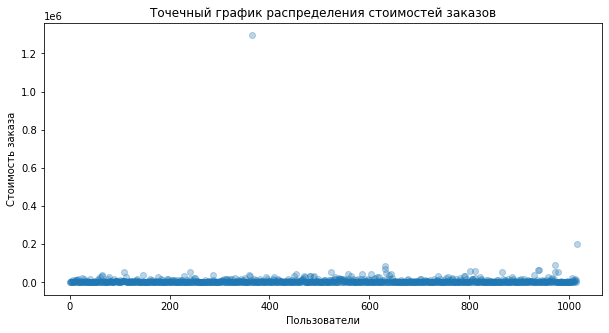

In [23]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.figure(figsize=(10, 5))
plt.scatter(x_values, orders['revenue'], alpha=0.3)
plt.title('Точечный график распределения стоимостей заказов')
plt.ylabel('Стоимость заказа')
plt.xlabel('Пользователи')
plt.show()

Посмотрим поближе

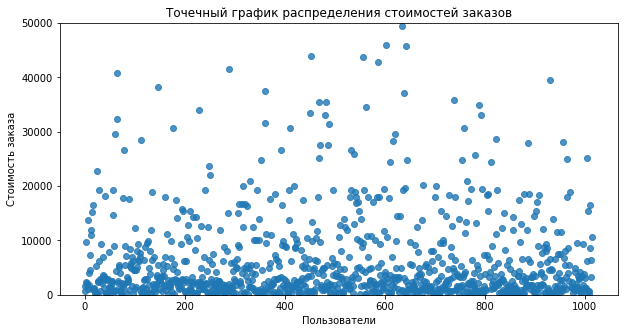

In [24]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.figure(figsize=(10, 5))
plt.scatter(x_values, orders['revenue'], alpha=0.8)
plt.ylim(0, 50000)
plt.title('Точечный график распределения стоимостей заказов')
plt.ylabel('Стоимость заказа')
plt.xlabel('Пользователи')
plt.show()

В основной массе заказы имеют стоимость <10 000р. На графике видно два резко выбивающихся из общей картины выброса, если в 20 тыс. еще нормальный, а вот 1,3 млн можно считать выбросом.

#### Посчитаем 95-й и 99-й перцентили стоимости заказов

In [25]:
np.percentile(orders['revenue'], [95, 99])

array([26785., 53904.])

**Можно сделать вывод, что 99% всех заказов по стоимости доходят до 53 904р. Заказы выше этой суммы  составляют менее 1 % от общего числа заказов.**

#### Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным.

Установим уровень значимости α = 5%<br>Применим статистический критерий Манна-Уитни<br>
H₀ - статистически значимых различий в конверсии между группами нет.<br>
H₁ - статистически значимые различия между группами есть.<br>
В случае если P-value < α, нулевая гипотеза отвергается<br>
Если P-value > α, отвергается альтернативная гипотеза

In [26]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitor_id', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitor_id', 'orders']

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print('P-value = '"{0:.5f}".format(st.mannwhitneyu(sampleA, sampleB)[1]))
print('Относительное различие в средней конверсии между группами по «сырым» данным: '"{0:.3f}"
      .format((data['ordersPerDateB'].sum()/
               data['visitorsPerDateB'].sum())
              /(data['ordersPerDateA'].sum()
                /data['visitorsPerDateA'].sum())-1))

P-value = 0.01102
Относительное различие в средней конверсии между группами по «сырым» данным: 0.160


P-value меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет, отвергаем в пользу альтернативной гипотезы - среднее число заказов на пользователя между группами различается.

#### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. 


Установим уровень значимости в 5%<br>
H₀ - статистически значимых различий в среднем чеке между группами нет <br>
H₁ - статистически значимые различия в среднем чеке между группами есть.

In [27]:
st.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])

MannwhitneyuResult(statistic=129236.5, pvalue=0.8294908998149533)

**P-value = 0.829 и значительно больше 0.05. Значит нулевую гипотезу не отвергаем и нельзя считать, что в среднем чеке есть различия.**

Посмотрим на сами различия в среднем чеке

In [28]:
print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

0.287


Различия в среднем чеке между группами составляют 28,7%

#### Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным.


Установим уровень значимости в 5%<br>
H₀ - статистически значимых различий в среднем количестве заказов между группами нет <br>
H₁ - статистически значие различия в среднем количестве заказов между группами есть.

Учтем за аномальных пользователей тех, у кого более 3 заказов или заказ дороже 53 904 р.

In [29]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > np.percentile(orders_by_users['orders'],99)]['visitor_id'],
        ordersByUsersB[ordersByUsersB['orders'] > np.percentile(orders_by_users['orders'],99)]['visitor_id'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > np.percentile(orders['revenue'], [95, 99])[1]]['visitor_id']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.shape[0]) 

16


Исключаем 16 пользователей

In [30]:
SampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 
print('{0:.3f}'.format(st.mannwhitneyu(SampleAFiltered, sampleBFiltered)[1]))
print('Количество заказов пользователя группы В превышает количество заказов группы А на ''{0:.3f}'.format(
    (sampleBFiltered.mean()/SampleAFiltered.mean()-1)*100),'%')

0.007
Количество заказов пользователя группы В превышает количество заказов группы А на 18.921 %


P-value = 0.007 и меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет, отвергаем в пользу альтернативной гипотезы - среднее число заказов на пользователя между группами различается.
Количество заказов пользователя группы В превышает количество заказов группы А на 18.921 % на очищенных данных

#### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным.


Установим уровень значимости в 5%<br>
H₀ - статистически значимых различий в среднем чеке заказа между группами по «очищенным» данным нет <br>
H₁ - статистически значимые различия между группами есть.

In [31]:
print(
    '{0:.3f}'.format(
        st.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

0.788


P-value = 0.788, что больше чем 0.05. Нулевую гипотезу о том,что в среднем чеке нет различия не отвергаем

In [32]:
print(
    '{0:.3f}'.format(
        orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean() /
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()-1
    )
)

0.033


Различия в среднем чеке не превышает 3,3%, следовательно нулевую гипотезу правильно не отвергли.

### Итоговое решение:

По результатам теста можно принять одно из возможных вариантов решений:<br>

✔️ Остановить тест, зафиксировать победу одной из групп.<br>
❌ Остановить тест, зафиксировать отсутствие различий между группами.<br>
❌ Продолжить тест.<br>

Тест показал, что количество заказов у пользователей группы В превышает количество заказов у группы А на 18.921 % по очищенным данным<br>
Нет статистически значимого различия по среднему чеку между группами A и B.<br>

По результатам теста при равном чеке, но большей конверсии заказов принять решение - зафиксировать победу группы В и остановить тест.<br> 

### Общий вывод

*Работа была разделена на две части.*<br>
**Часть 1:**<br>
- В обоих случаях (ICE и RICE) гипотеза №0 и №7 входят в тройку, что показывает перспективу дальнейшего развития гипотез.
- Наболее перспективная гипотеза по ICE под номером 8(Запустить акцию на скидку ко дню рождения) опустилось на пятое место при расчете RICE. Это объясняется показателем reach - количество пользователей, которое затронет изменение.в случае с гипотезой №7 данный показатель равен 10, а с доминирующей гипотезой №8 по ICE значение reach = 1. 
- "Запустить акцию, дающую скидку на товар в день рождения" - потенциально выгодно для удержания и привлечения пользователей, но коснется оно небольшого числа людей(многие не хотят давать перс. данные или просто не указывают дату рождения), поэтому фреймворк RISE опустил данный метод на 5 место по приоритету.<br><br>
Необходимо сфокусироваться на гипотезах №0 и №7: 
1. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
2. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок	

**Часть 2:**<br>
Исключив пользователей, которые попали в обе группы, можно сделать выводы, что:
- Основная масса пользователей за представленный период ограничилась 1,2 заказами на сумму не более 10 000 рублей по обеим исследуемым группам.<br>
- Среднее количество заказов на 18,9% у группы В превышает количество заказов у группы А. 
- Значимые изменения по среднему чеку отсутствуют( изменения составили 3,3%). 
- По результатам теста при равном чеке, но большей конверсии заказов принять решение - зафиксировать победу группы В и остановить тест.
- В конечном счете итоговая выручка увеличилась, так как покупки через сайт стали чаще.